In [1]:
"""
Notebook for training the embedding model for the flow around cylinder system.
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: https://arxiv.org/abs/2010.03957
doi: 
github: https://github.com/zabaras/transformer-physx
=====
"""
!nvidia-smi

Sun Jul 25 19:38:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Environment Setup

Use pip to install from [PyPI](https://pypi.org/project/trphysx/).

In [3]:
!pip install trphysx

Mount google drive and create a folder to work in.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/
% mkdir -p transformer_physx/cylinder
% cd transformer_physx/cylinder

/content/gdrive/MyDrive
/content/gdrive/MyDrive/transformer_physx/cylinder


Now lets download the training and validation data for the lorenz system. Info on wget from [Google drive](https://stackoverflow.com/questions/37453841/download-a-file-from-google-drive-using-wget). This will eventually be update to zenodo repo.

In [6]:
!mkdir data

**WARNING: Training datafile is 1.3Gb! Validation is 0.35Gb!** These will be stored in your Google drive!

Because this is a big datafile, we will use gdown to instead of wget because of virus warning from google drive.

In [14]:
!pip install gdown
import gdown
gdown.download("https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v", "./data/cylinder_training.hdf5", quiet=False)
gdown.download("https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws", "./data/cylinder_valid.hdf5", quiet=False)
# !wget -O ./data/cylinder_training.hdf5 "https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v"
# !wget -O ./data/cylinder_valid.hdf5 "https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws"

Downloading...
From: https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v
To: /content/gdrive/My Drive/transformer_physx/cylinder/data/cylinder_training.hdf5
1.29GB [00:08, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws
To: /content/gdrive/My Drive/transformer_physx/cylinder/data/cylinder_valid.hdf5
342MB [00:09, 34.9MB/s]


'./data/cylinder_valid.hdf5'

# Transformer-PhysX Cylinder System

Train the embedding model.
First import necessary modules from trphysx. 

In [16]:
import sys
import logging

import torch
from torch.optim.lr_scheduler import ExponentialLR

from trphysx.config.configuration_auto import AutoPhysConfig
from trphysx.embedding.embedding_auto import AutoEmbeddingModel
from trphysx.viz.viz_auto import AutoViz
from trphysx.embedding.training import *

logger = logging.getLogger(__name__)

Training arguments.

In [25]:
argv = []
argv = argv + ["--exp_name", "cylinder"]
argv = argv + ["--training_h5_file", "./data/cylinder_training.hdf5"]
argv = argv + ["--eval_h5_file", "./data/cylinder_valid.hdf5"]
argv = argv + ["--batch_size", "32"]
argv = argv + ["--block_size", "4"]
argv = argv + ["--ntrain", "27"]
argv = argv + ["--epochs", "100"]

In [26]:
args = EmbeddingParser().parse(args=argv)  

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO)

if(torch.cuda.is_available()):
    use_cuda = "cuda"
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info("Torch device: {}".format(args.device))

07/25/2021 19:57:10 - INFO - __main__ -   Torch device: cuda:0


## Initializing Datasets and Models

Now we can use the auto classes to initialized the predefined configs, dataloaders and models. This may take a bit!

In [27]:
# Load transformer config file
config = AutoPhysConfig.load_config(args.exp_name)
data_handler = AutoDataHandler.load_data_handler(args.exp_name)
viz = AutoViz.load_viz(args.exp_name, plot_dir=args.plot_dir)

  # Set up data-loaders
training_loader = data_handler.createTrainingLoader(
                        args.training_h5_file, 
                        block_size=args.block_size, 
                        stride=args.stride, 
                        ndata=args.ntrain, 
                        batch_size=args.batch_size)
testing_loader = data_handler.createTestingLoader(
                    args.eval_h5_file, 
                    block_size=32, 
                    ndata=args.ntest, 
                    batch_size=8)

# Set up model
model = AutoEmbeddingModel.init_trainer(args.exp_name, config).to(args.device)
mu, std = data_handler.norm_params
model.embedding_model.mu = mu.to(args.device)
model.embedding_model.std = std.to(args.device)
if args.epoch_start > 1:
    model.load_model(args.ckpt_dir, args.epoch_start)


07/25/2021 19:57:27 - INFO - root -   Creating training loader
07/25/2021 19:58:06 - INFO - root -   Creating testing loader
07/25/2021 19:58:14 - WARNING - root -   Lower batch-size to 6
07/25/2021 19:58:14 - INFO - trphysx.embedding.embedding_cylinder -   Number of embedding parameters: 224134


Initialize optimizer and scheduler. Feel free to change if you want to experiment.

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr*0.995**(args.epoch_start-1), weight_decay=1e-8)
scheduler = ExponentialLR(optimizer, gamma=0.995)

## Training the Embedding Model

This notebook only trains for 100 epochs for brevity, feel free to train longer. The test loss here is only the recovery loss MSE(x - decode(encode(x))) and does not reflect the quality of the Koopman dynamics.

In [29]:
trainer = EmbeddingTrainer(model, args, (optimizer, scheduler), viz)
trainer.train(training_loader, testing_loader)

07/25/2021 20:00:33 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 1: Training loss 11411.085, Lr 0.00100


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:00:35 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 1: Test loss: 0.03
07/25/2021 20:00:41 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 2: Training loss 3508.269, Lr 0.00099
07/25/2021 20:00:46 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 3: Training loss 1705.150, Lr 0.00099
07/25/2021 20:00:52 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 4: Training loss 976.556, Lr 0.00099
07/25/2021 20:00:58 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 5: Training loss 717.974, Lr 0.00098


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:01:00 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 5: Test loss: 0.00
07/25/2021 20:01:06 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 6: Training loss 622.105, Lr 0.00098
07/25/2021 20:01:12 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 7: Training loss 535.747, Lr 0.00097
07/25/2021 20:01:18 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 8: Training loss 482.296, Lr 0.00097
07/25/2021 20:01:24 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 9: Training loss 457.621, Lr 0.00096
07/25/2021 20:01:30 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 10: Training loss 389.275, Lr 0.00096


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:01:31 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 10: Test loss: 0.00
07/25/2021 20:01:37 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 11: Training loss 397.383, Lr 0.00095
07/25/2021 20:01:44 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 12: Training loss 393.644, Lr 0.00095
07/25/2021 20:01:50 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 13: Training loss 318.708, Lr 0.00094
07/25/2021 20:01:56 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 14: Training loss 313.105, Lr 0.00094
07/25/2021 20:02:02 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 15: Training loss 298.027, Lr 0.00093


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:02:03 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 15: Test loss: 0.00
07/25/2021 20:02:09 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 16: Training loss 274.498, Lr 0.00093
07/25/2021 20:02:16 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 17: Training loss 282.038, Lr 0.00092
07/25/2021 20:02:22 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 18: Training loss 254.173, Lr 0.00092
07/25/2021 20:02:28 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 19: Training loss 244.758, Lr 0.00091
07/25/2021 20:02:34 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 20: Training loss 226.311, Lr 0.00091


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:02:35 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 20: Test loss: 0.00
07/25/2021 20:02:42 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 21: Training loss 248.028, Lr 0.00090
07/25/2021 20:02:48 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 22: Training loss 219.176, Lr 0.00090
07/25/2021 20:02:54 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 23: Training loss 225.359, Lr 0.00090
07/25/2021 20:03:00 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 24: Training loss 197.365, Lr 0.00089
07/25/2021 20:03:06 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 25: Training loss 187.653, Lr 0.00089


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:03:08 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 25: Test loss: 0.00
07/25/2021 20:03:08 - INFO - trphysx.embedding.training.enn_trainer -   Checkpointing model, optimizer and scheduler.
07/25/2021 20:03:14 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 26: Training loss 178.887, Lr 0.00088
07/25/2021 20:03:20 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 27: Training loss 174.929, Lr 0.00088
07/25/2021 20:03:27 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 28: Training loss 200.227, Lr 0.00087
07/25/2021 20:03:33 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 29: Training loss 184.874, Lr 0.00087
07/25/2021 20:03:39 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 30: Training loss 184.476, Lr 0.00086


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:03:40 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 30: Test loss: 0.00
07/25/2021 20:03:47 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 31: Training loss 185.326, Lr 0.00086
07/25/2021 20:03:53 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 32: Training loss 168.980, Lr 0.00086
07/25/2021 20:03:59 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 33: Training loss 162.225, Lr 0.00085
07/25/2021 20:04:05 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 34: Training loss 155.103, Lr 0.00085
07/25/2021 20:04:11 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 35: Training loss 152.831, Lr 0.00084


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:04:13 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 35: Test loss: 0.00
07/25/2021 20:04:19 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 36: Training loss 157.103, Lr 0.00084
07/25/2021 20:04:25 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 37: Training loss 146.529, Lr 0.00083
07/25/2021 20:04:31 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 38: Training loss 138.074, Lr 0.00083
07/25/2021 20:04:37 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 39: Training loss 131.507, Lr 0.00083
07/25/2021 20:04:44 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 40: Training loss 154.370, Lr 0.00082


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:04:45 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 40: Test loss: 0.00
07/25/2021 20:04:51 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 41: Training loss 174.477, Lr 0.00082
07/25/2021 20:04:57 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 42: Training loss 155.510, Lr 0.00081
07/25/2021 20:05:04 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 43: Training loss 143.090, Lr 0.00081
07/25/2021 20:05:10 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 44: Training loss 137.167, Lr 0.00081
07/25/2021 20:05:16 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 45: Training loss 128.744, Lr 0.00080


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:05:17 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 45: Test loss: 0.00
07/25/2021 20:05:24 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 46: Training loss 130.968, Lr 0.00080
07/25/2021 20:05:30 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 47: Training loss 130.125, Lr 0.00079
07/25/2021 20:05:36 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 48: Training loss 122.001, Lr 0.00079
07/25/2021 20:05:42 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 49: Training loss 118.546, Lr 0.00079
07/25/2021 20:05:48 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 50: Training loss 114.851, Lr 0.00078


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:05:50 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 50: Test loss: 0.00
07/25/2021 20:05:50 - INFO - trphysx.embedding.training.enn_trainer -   Checkpointing model, optimizer and scheduler.
07/25/2021 20:05:56 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 51: Training loss 113.633, Lr 0.00078
07/25/2021 20:06:02 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 52: Training loss 109.753, Lr 0.00077
07/25/2021 20:06:08 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 53: Training loss 110.559, Lr 0.00077
07/25/2021 20:06:14 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 54: Training loss 119.336, Lr 0.00077
07/25/2021 20:06:21 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 55: Training loss 113.119, Lr 0.00076


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:06:22 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 55: Test loss: 0.00
07/25/2021 20:06:28 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 56: Training loss 111.361, Lr 0.00076
07/25/2021 20:06:34 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 57: Training loss 107.617, Lr 0.00076
07/25/2021 20:06:40 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 58: Training loss 106.361, Lr 0.00075
07/25/2021 20:06:47 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 59: Training loss 103.025, Lr 0.00075
07/25/2021 20:06:53 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 60: Training loss 103.466, Lr 0.00074


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:06:54 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 60: Test loss: 0.00
07/25/2021 20:07:00 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 61: Training loss 101.352, Lr 0.00074
07/25/2021 20:07:06 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 62: Training loss 100.431, Lr 0.00074
07/25/2021 20:07:12 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 63: Training loss 97.993, Lr 0.00073
07/25/2021 20:07:19 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 64: Training loss 96.553, Lr 0.00073
07/25/2021 20:07:25 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 65: Training loss 97.305, Lr 0.00073


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:07:26 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 65: Test loss: 0.00
07/25/2021 20:07:32 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 66: Training loss 95.655, Lr 0.00072
07/25/2021 20:07:39 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 67: Training loss 96.217, Lr 0.00072
07/25/2021 20:07:45 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 68: Training loss 99.214, Lr 0.00071
07/25/2021 20:07:51 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 69: Training loss 91.720, Lr 0.00071
07/25/2021 20:07:57 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 70: Training loss 89.624, Lr 0.00071


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:07:59 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 70: Test loss: 0.00
07/25/2021 20:08:05 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 71: Training loss 88.242, Lr 0.00070
07/25/2021 20:08:11 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 72: Training loss 89.842, Lr 0.00070
07/25/2021 20:08:17 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 73: Training loss 90.967, Lr 0.00070
07/25/2021 20:08:23 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 74: Training loss 87.594, Lr 0.00069
07/25/2021 20:08:30 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 75: Training loss 87.867, Lr 0.00069


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:08:31 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 75: Test loss: 0.00
07/25/2021 20:08:31 - INFO - trphysx.embedding.training.enn_trainer -   Checkpointing model, optimizer and scheduler.
07/25/2021 20:08:37 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 76: Training loss 84.473, Lr 0.00069
07/25/2021 20:08:43 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 77: Training loss 83.161, Lr 0.00068
07/25/2021 20:08:49 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 78: Training loss 88.703, Lr 0.00068
07/25/2021 20:08:56 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 79: Training loss 85.844, Lr 0.00068
07/25/2021 20:09:02 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 80: Training loss 82.578, Lr 0.00067


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:09:03 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 80: Test loss: 0.00
07/25/2021 20:09:09 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 81: Training loss 80.294, Lr 0.00067
07/25/2021 20:09:16 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 82: Training loss 79.051, Lr 0.00067
07/25/2021 20:09:22 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 83: Training loss 78.111, Lr 0.00066
07/25/2021 20:09:28 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 84: Training loss 76.667, Lr 0.00066
07/25/2021 20:09:34 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 85: Training loss 75.471, Lr 0.00066


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:09:35 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 85: Test loss: 0.00
07/25/2021 20:09:41 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 86: Training loss 74.531, Lr 0.00065
07/25/2021 20:09:48 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 87: Training loss 73.227, Lr 0.00065
07/25/2021 20:09:54 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 88: Training loss 73.566, Lr 0.00065
07/25/2021 20:10:00 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 89: Training loss 72.525, Lr 0.00064
07/25/2021 20:10:06 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 90: Training loss 71.959, Lr 0.00064


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:10:08 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 90: Test loss: 0.00
07/25/2021 20:10:14 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 91: Training loss 71.144, Lr 0.00064
07/25/2021 20:10:20 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 92: Training loss 70.293, Lr 0.00063
07/25/2021 20:10:27 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 93: Training loss 73.104, Lr 0.00063
07/25/2021 20:10:33 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 94: Training loss 75.269, Lr 0.00063
07/25/2021 20:10:39 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 95: Training loss 75.543, Lr 0.00062


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:10:41 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 95: Test loss: 0.00
07/25/2021 20:10:47 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 96: Training loss 77.325, Lr 0.00062
07/25/2021 20:10:53 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 97: Training loss 75.145, Lr 0.00062
07/25/2021 20:10:59 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 98: Training loss 74.535, Lr 0.00061
07/25/2021 20:11:05 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 99: Training loss 72.393, Lr 0.00061
07/25/2021 20:11:12 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 100: Training loss 72.713, Lr 0.00061


torch.Size([6, 31, 3, 64, 128])


07/25/2021 20:11:13 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 100: Test loss: 0.00
07/25/2021 20:11:13 - INFO - trphysx.embedding.training.enn_trainer -   Checkpointing model, optimizer and scheduler.


Check your Google drive for checkpoints.

## Visualization of Results

Embed some test predictions of the embedding model, this is simply showing the prediction of the model of one Koopman step. I.e. x(t+1) = decoder(K*encoder(x(t))). Random time-steps are plotted.

Validation prediction for epoch: 1


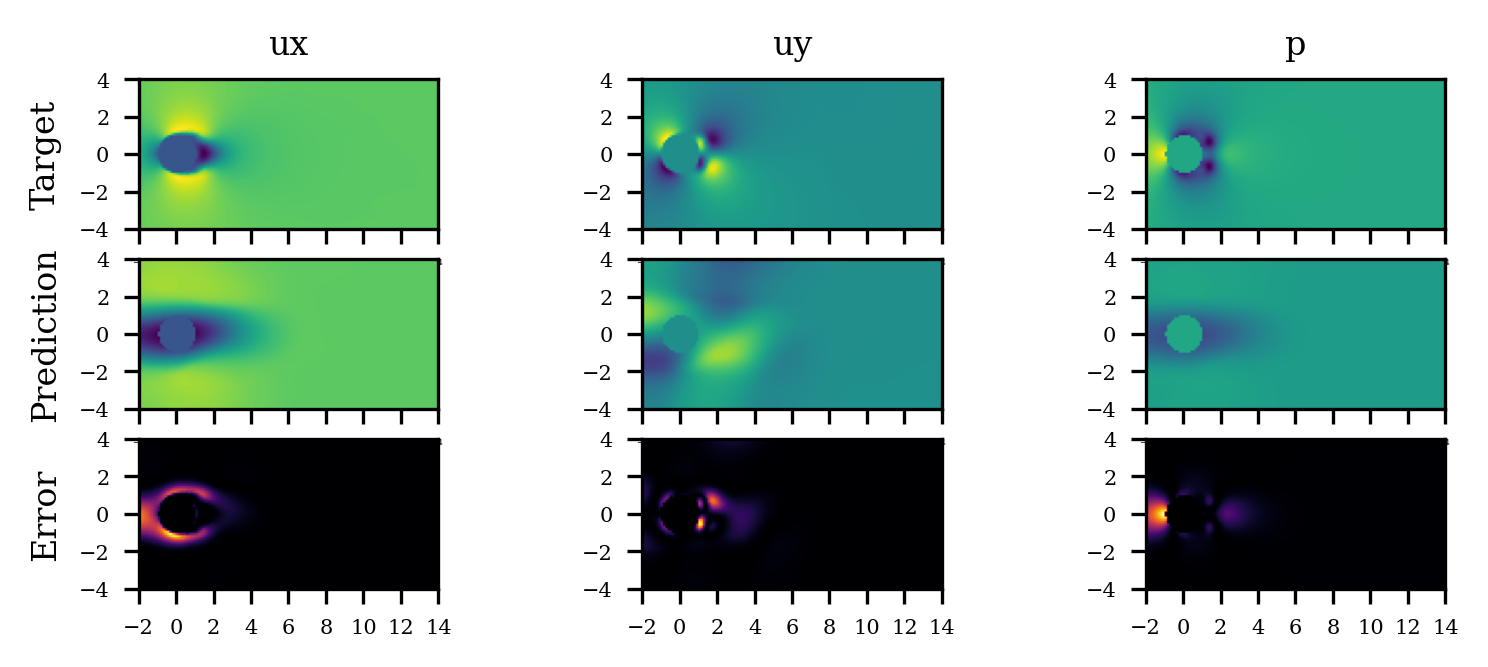

Validation prediction for epoch: 25


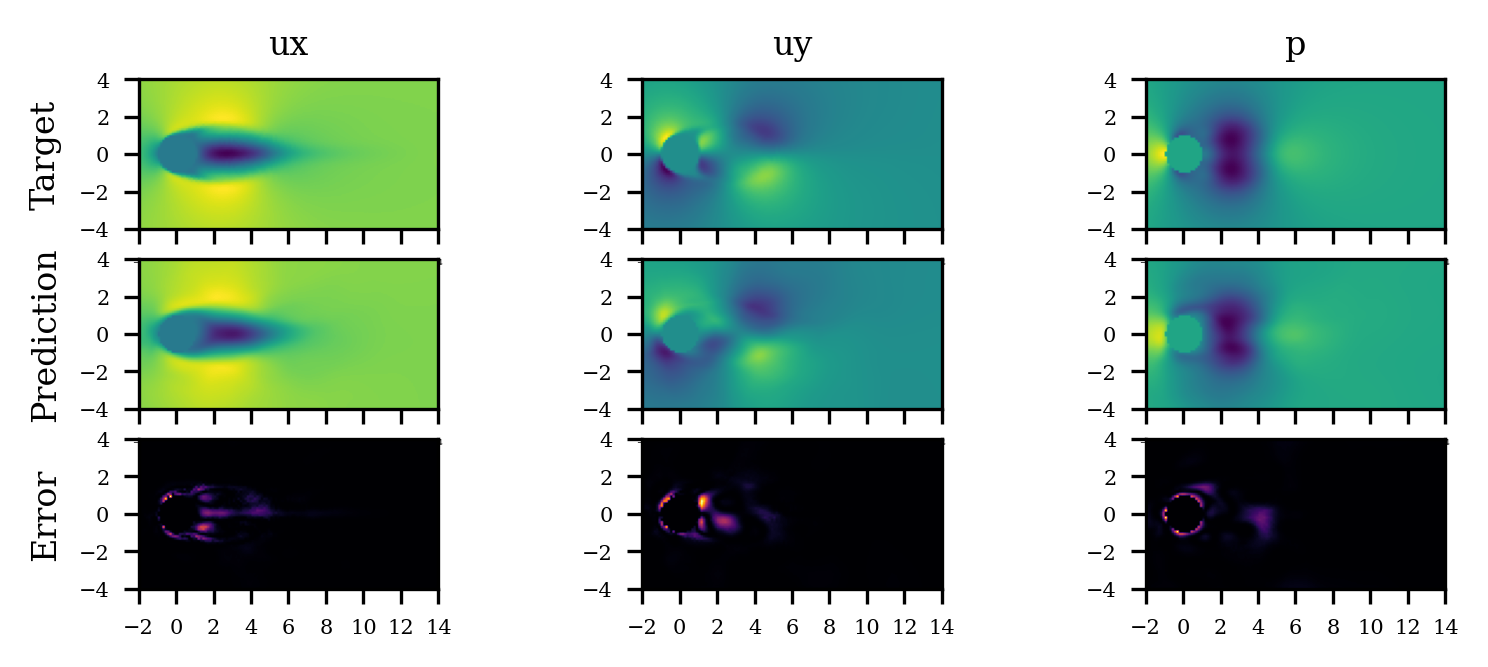

Validation prediction for epoch: 50


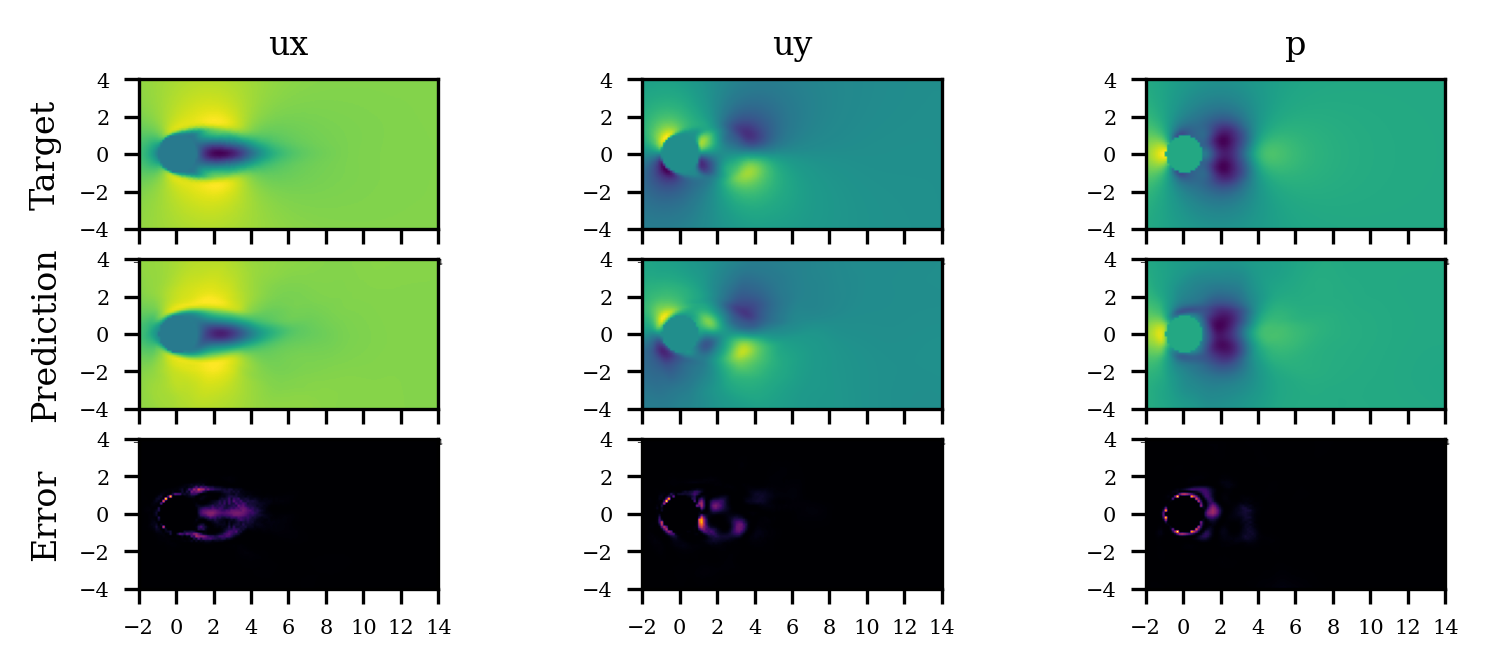

Validation prediction for epoch: 75


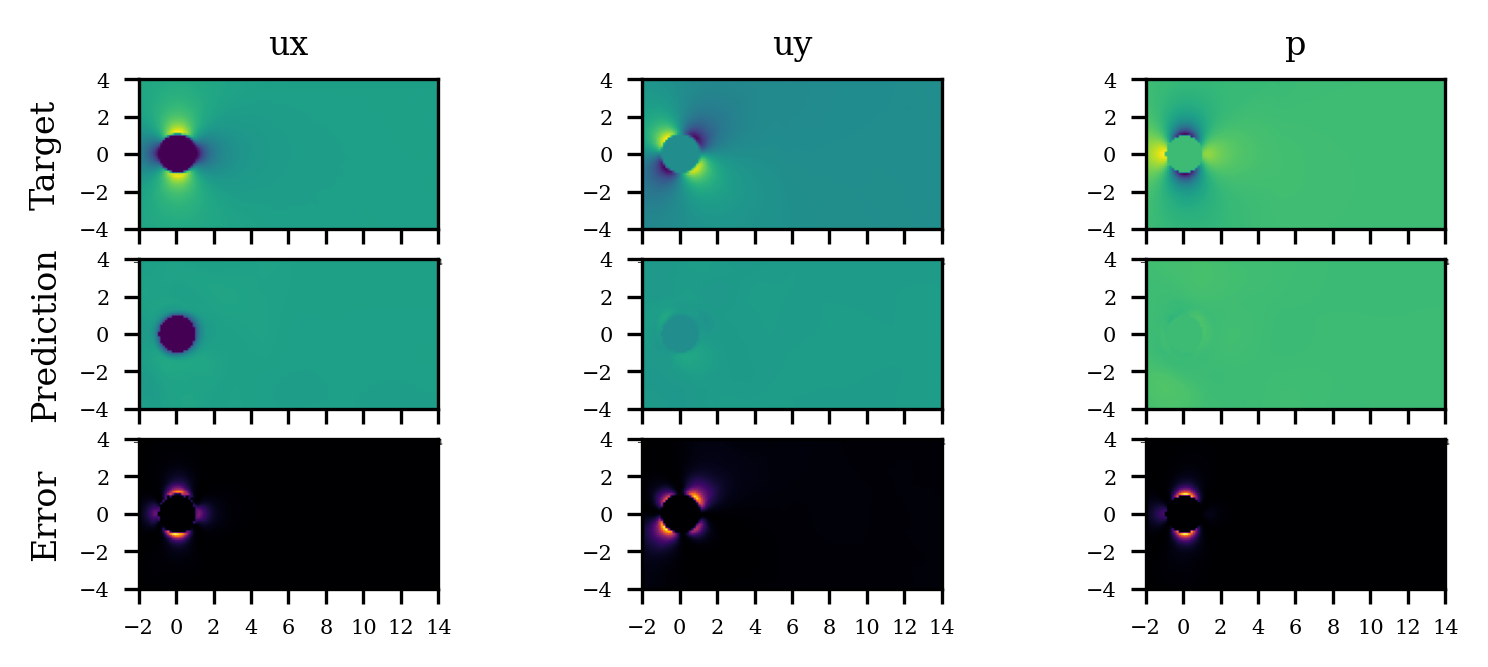

Validation prediction for epoch: 100


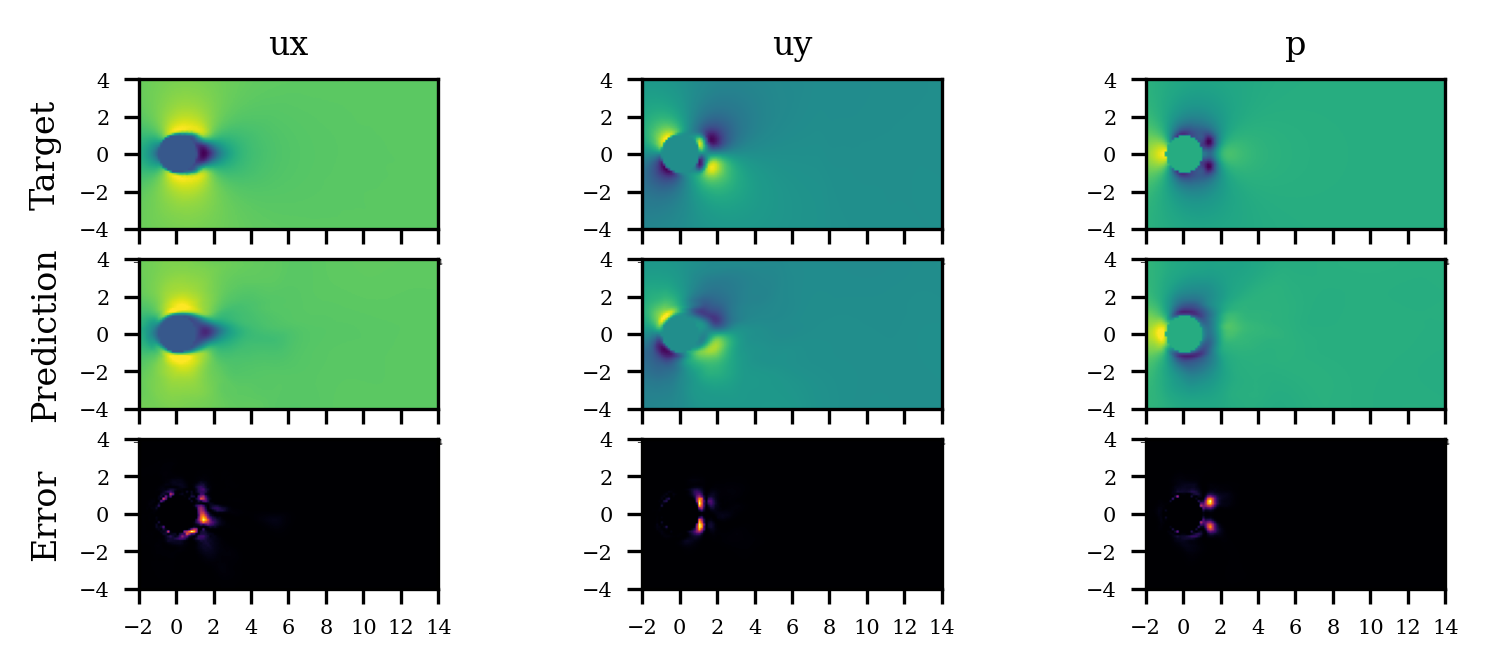

In [31]:
from IPython.display import Image, display

for epoch in [1, 25, 50, 75, 100]:
  print('Validation prediction for epoch: {:d}'.format(epoch))
  file_path = './outputs/embedding_cylinder/ntrain27_epochs100_batch32/predictions/embeddingPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=600, height=300))